In [10]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim


env = gym.make('FrozenLake-v1', is_slippery=True)

Divisão do passo-a-passo:
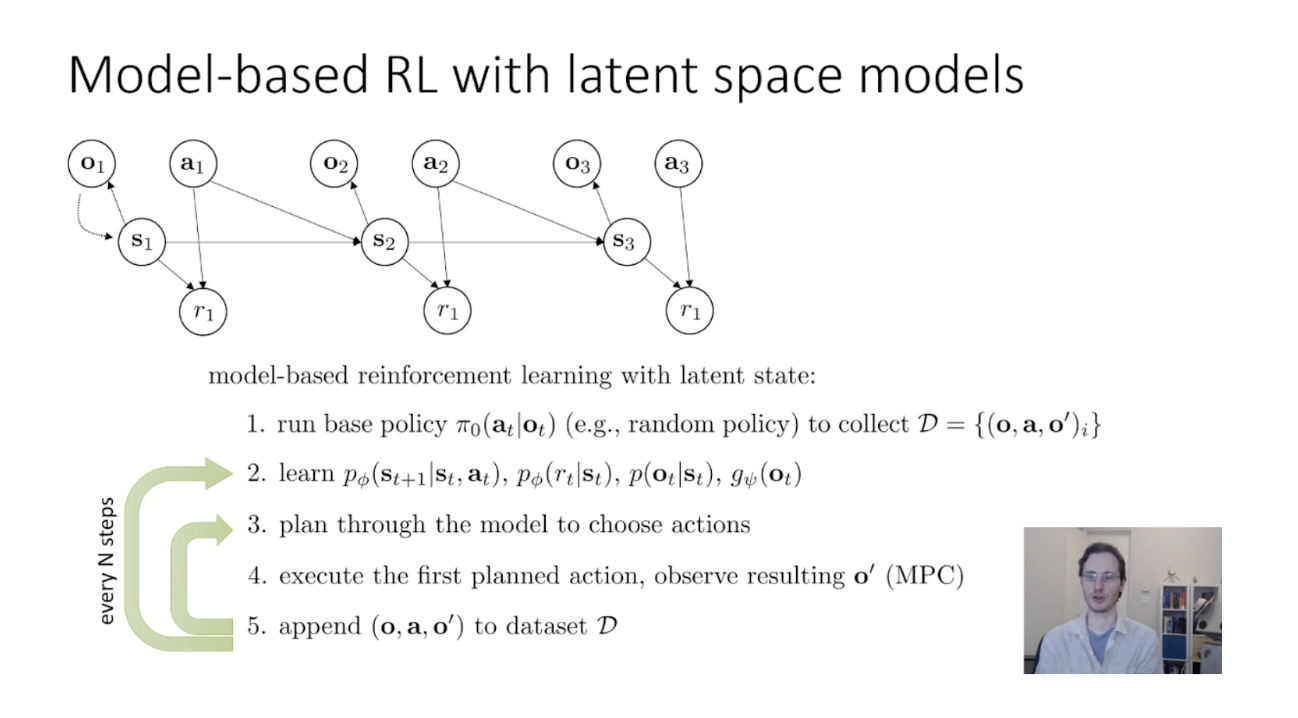

## Run base policy

In [11]:

def generate_dataset(env, num_episodes):
    """
    Gera um conjunto de dados estruturado em episódios.

    Args:
        env: O ambiente OpenAI Gym.
        num_episodes: Número de episódios a serem gerados.

    Returns:
        episodes: Lista de episódios, onde cada episódio é uma lista de transições.
    """
    episodes = []

    for _ in range(num_episodes):
        state = env.reset()
        episode = []
        done = False
        truncated = False

        while not (done or truncated):
            action = env.action_space.sample()  # Ação aleatória
            next_state, reward, done, truncated, _ = env.step(action)

            if type(state) == tuple:  # Tratando estados que podem ser tuplas
                state = state[0]

            # Adicionar a transição ao episódio
            episode.append((state, int(action), reward, next_state))
            state = next_state

        # Adicionar o episódio à lista de episódios
        episodes.append(episode)

    return episodes

num_episodes = 1000
episodes = generate_dataset(env, num_episodes)

# Exibindo informações sobre o conjunto de dados
print(f"Total de episódios gerados: {len(episodes)}")
print(f"Exemplo de transição no primeiro episódio: {episodes[0][1]}")  # Primeira transição do primeiro episódio
print(f"Tamanho do primeiro episódio: {len(episodes[0])}")
print(f"Exemplo de episódio: {episodes[0]}")

# Fechando o ambiente
env.close()

Total de episódios gerados: 1000
Exemplo de transição no primeiro episódio: (0, 3, 0.0, 0)
Tamanho do primeiro episódio: 15
Exemplo de episódio: [(0, 2, 0.0, 0), (0, 3, 0.0, 0), (0, 3, 0.0, 0), (0, 3, 0.0, 0), (0, 0, 0.0, 0), (0, 1, 0.0, 4), (4, 1, 0.0, 8), (8, 0, 0.0, 4), (4, 2, 0.0, 0), (0, 0, 0.0, 0), (0, 3, 0.0, 0), (0, 2, 0.0, 4), (4, 0, 0.0, 8), (8, 1, 0.0, 9), (9, 3, 0.0, 5)]


## Learn the models

### Encoder do espaço latente

Usamos apenas um embedding para mapear as relacoes entre os dados, pois o jogo é simples

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, latent_dim)
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, state):
        embedded = self.embedding(state)
        return self.fc(embedded)

encoder = Encoder(input_dim=16, latent_dim=8)


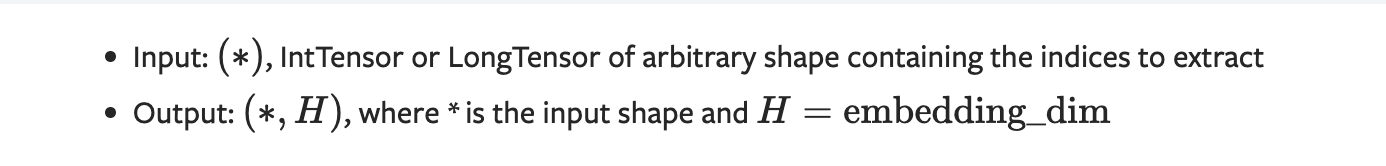

### Criando o decoder p(Ot|St)

In [13]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64), 
            nn.ReLU(),                 
            nn.Linear(64, output_dim), 
            nn.Softmax(dim=-1)        
        )

    def forward(self, latent_state):
        return self.fc(latent_state)

decoder = Decoder(latent_dim=8, output_dim=16)  

In [14]:
state = torch.tensor([0])  

latent_state = encoder(state)

# Passa o espaço latente pelo decoder para obter as probabilidades de cada observação
observation_probs = decoder(latent_state)
print("Probabilidades de observação:", observation_probs)


Probabilidades de observação: tensor([[0.0567, 0.0563, 0.0596, 0.0607, 0.0629, 0.0622, 0.0721, 0.0641, 0.0603,
         0.0698, 0.0579, 0.0570, 0.0616, 0.0656, 0.0689, 0.0643]],
       grad_fn=<SoftmaxBackward0>)


In [15]:
import random

def create_batches(data, batch_size):
    random.shuffle(data)
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

In [16]:
# Pré-processar o dataset para extrair estados e próximos estados
state_pairs = []
for episode in episodes:
    for transition in episode:
        state, _, _, next_state = transition
        state_pairs.append((state, next_state))

# Verificar o tamanho do dataset
print(f"Número total de transições no dataset: {len(state_pairs)}")


Número total de transições no dataset: 7657


In [20]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

# Hyperparâmetros
num_epochs = 100
batch_size = 8

In [21]:
# Loop de treinamento
for epoch in range(num_epochs):
    total_loss = 0.0
    batches = create_batches(state_pairs, batch_size)
    
    for batch in batches:
        # Separar estados e próximos estados no batch
        states, next_states = zip(*batch)
        states = torch.tensor(states, dtype=torch.long)  # Entrada do encoder
        next_states = torch.tensor(next_states, dtype=torch.long)  # Alvo para o decoder

        # Passar os estados pelo encoder e decoder
        latent_states = encoder(states)
        predicted_probs = decoder(latent_states)

        # Calcular a perda
        loss = criterion(predicted_probs, next_states)

        # Backpropagation e atualização dos pesos
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")


Epoch 1/100, Loss: 2376.1983
Epoch 2/100, Loss: 2375.8411
Epoch 3/100, Loss: 2374.1504
Epoch 4/100, Loss: 2377.4501
Epoch 5/100, Loss: 2375.2247
Epoch 6/100, Loss: 2374.4973
Epoch 7/100, Loss: 2376.8044
Epoch 8/100, Loss: 2375.4501
Epoch 9/100, Loss: 2375.1332
Epoch 10/100, Loss: 2374.8946
Epoch 11/100, Loss: 2374.4518
Epoch 12/100, Loss: 2374.2300
Epoch 13/100, Loss: 2373.8585
Epoch 14/100, Loss: 2377.3675
Epoch 15/100, Loss: 2374.6813
Epoch 16/100, Loss: 2374.0694
Epoch 17/100, Loss: 2373.9833
Epoch 18/100, Loss: 2374.1617
Epoch 19/100, Loss: 2373.5478
Epoch 20/100, Loss: 2373.9761
Epoch 21/100, Loss: 2374.1717
Epoch 22/100, Loss: 2374.0733
Epoch 23/100, Loss: 2374.0014
Epoch 24/100, Loss: 2374.3370
Epoch 25/100, Loss: 2374.1592
Epoch 26/100, Loss: 2372.9113
Epoch 27/100, Loss: 2373.5010
Epoch 28/100, Loss: 2374.2180
Epoch 29/100, Loss: 2373.7488
Epoch 30/100, Loss: 2373.4946
Epoch 31/100, Loss: 2374.1685
Epoch 32/100, Loss: 2374.9251
Epoch 33/100, Loss: 2374.4153
Epoch 34/100, Loss:

In [16]:
# Testar com algumas transições
for i in range(5):  # Testar nas 5 primeiras transições
    state, next_state = state_pairs[i]
    state_tensor = torch.tensor([state], dtype=torch.long)

    # Passar pelo encoder e decoder
    latent_state = encoder(state_tensor)
    predicted_probs = decoder(latent_state)

    print(f"Estado atual: {state}")
    print(f"Próximo estado real: {next_state}")
    print(f"Próximo estado previsto: {torch.argmax(predicted_probs, dim=-1).item()}")
    print(f"Probabilidades previstas: {predicted_probs.squeeze().detach().numpy()}\n")


Estado atual: 1
Próximo estado real: 2
Próximo estado previsto: 0
Probabilidades previstas: [5.4805654e-01 2.5738841e-01 2.6418881e-02 1.5350599e-04 3.0087720e-05
 1.6751531e-01 4.2031646e-05 4.0720915e-05 1.7245700e-04 1.0639920e-05
 2.2926100e-05 7.2885232e-06 5.4790700e-05 5.5565570e-06 6.5829401e-05
 1.5029914e-05]

Estado atual: 3
Próximo estado real: 3
Próximo estado previsto: 3
Probabilidades previstas: [1.1660795e-05 7.2522107e-06 1.9012847e-06 9.9996901e-01 1.4032748e-09
 6.2496028e-06 5.1162743e-08 8.9372296e-14 3.7110960e-06 1.3959283e-09
 3.7576227e-09 5.9825855e-10 1.2214163e-07 2.8976764e-11 4.7432199e-08
 2.9489893e-11]

Estado atual: 0
Próximo estado real: 0
Próximo estado previsto: 0
Probabilidades previstas: [9.9998868e-01 1.0635371e-05 3.2010601e-09 6.0094964e-11 5.1630887e-11
 6.8496439e-07 7.3396455e-14 7.7788380e-15 4.9275046e-09 8.9772983e-14
 3.4598306e-13 8.5743333e-15 6.1084909e-10 5.7659858e-15 7.8206457e-14
 1.3805977e-17]

Estado atual: 1
Próximo estado rea

In [ ]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

# Hyperparâmetros
num_epochs = 20
batch_size = 32

### Criando o modelo de recompensa

In [ ]:
class Reward_Model(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Reward_Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64), 
            nn.ReLU(),                 
            nn.Linear(64, output_dim), 
            nn.Softmax(dim=-1)        
        )

    def forward(self, latent_state):
        return self.fc(latent_state)

reward_model = Reward_Model(latent_dim=8, output_dim=1)  

### Criando o modelo de mundo

## MPC